In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from skimage.transform import resize

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self,env)        
        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def _observation(self, img):
        img = img[31:-16,7:-7,:]
        img = resize(img, self.img_size)
        img = img.mean(-1, keepdims=True)
        img = img.astype('float32') / 255.
        return img

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
3
(64, 64, 1)
Formal tests seem fine. Here's an example of what you'll get.


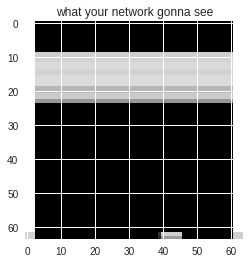

In [47]:
#spawn game instance for tests
env = gym.make("BreakoutDeterministic-v0") #create raw env
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

# test observation
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs))>2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(obs) <=1, "convert image pixels to (0,1) range"

print("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');

In [0]:
from gym.core import Wrapper

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info
    
    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

In [48]:
def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
x = env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(n_actions)
print(state_dim)

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
4
(64, 64, 4)


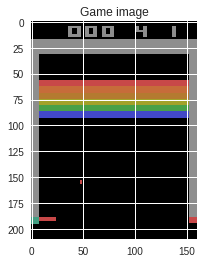

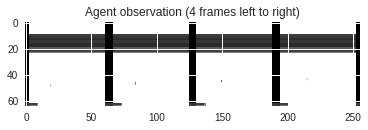

In [49]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

In [50]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
from keras.layers import Conv2D, Dense, Flatten
from keras.models import Sequential
import random

class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        with tf.variable_scope(name, reuse=reuse):            
            self.model = Sequential()    
            self.model.add(Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape))
            self.model.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
            self.model.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
            self.model.add(Flatten())
            self.model.add(Dense(256, activation='relu'))
            self.model.add(Dense(n_actions, activation='linear'))
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)
            
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""        
        qvalues = self.model(state_t)        
        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions
        
        return qvalues
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})
    
    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [0]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.99)
sess.run(tf.global_variables_initializer())

In [0]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done: break
                
        rewards.append(reward)
    return np.mean(rewards)

In [55]:
evaluate(env, agent, n_games=1)

0.0

In [0]:
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx == len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

In [0]:
exp_replay = ReplayBuffer(10)
for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [0]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    # initial state
    s = env.framebuffer    
    reward = 0.0
    for i in range(n_steps):
        a = agent.sample_actions(agent.get_qvalues([s]))[0]
        next_s, r, done, _ = env.step(a)        
        exp_replay.add(s, a, r, next_s, done)
        reward += r
        if done:
            s = env.reset()
        else:
            s = next_s
    return reward

In [58]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction. 
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i"%len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]"%(np.mean(is_dones), len(exp_replay))
    
for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s"%str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s"%str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s"%str(is_done_batch.shape)
    assert [int(i) in (0,1) for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"
    
print("Well done!")

Well done!


In [0]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [0]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)

In [61]:
copy_step = load_weigths_into_target_network(agent, target_network)
sess.run(copy_step) 

# check that it works
sess.run([tf.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)]);
print("It works!")

It works!


In [0]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

In [0]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

In [0]:
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)
next_state_values_target = tf.math.reduce_max(next_qvalues_target, axis=-1)
reference_qvalues = rewards_ph + is_not_done * next_state_values_target * gamma

# Define loss function for sgd.
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

In [0]:
sess.run(tf.global_variables_initializer())

In [66]:
for chk_grad in tf.gradients(reference_qvalues, agent.weights):
    error_msg = "Reference q-values should have no gradient w.r.t. agent weights. Make sure you used target_network qvalues! "
    error_msg += "If you know what you're doing, ignore this assert."
    assert chk_grad is None or np.allclose(sess.run(chk_grad), sess.run(chk_grad * 0)), error_msg

assert tf.gradients(reference_qvalues, is_not_done)[0] is not None, "make sure you used is_not_done"
assert tf.gradients(reference_qvalues, rewards_ph)[0] is not None, "make sure you used rewards"
assert tf.gradients(reference_qvalues, next_obs_ph)[0] is not None, "make sure you used next states"
assert tf.gradients(reference_qvalues, obs_ph)[0] is None, "reference qvalues shouldn't depend on current observation!" # ignore if you're certain it's ok
print("Splendid!")

Splendid!


In [0]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

mean_rw_history = []
td_loss_history = []

In [0]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)

def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

buffer size = 100000, epsilon = 0.42677


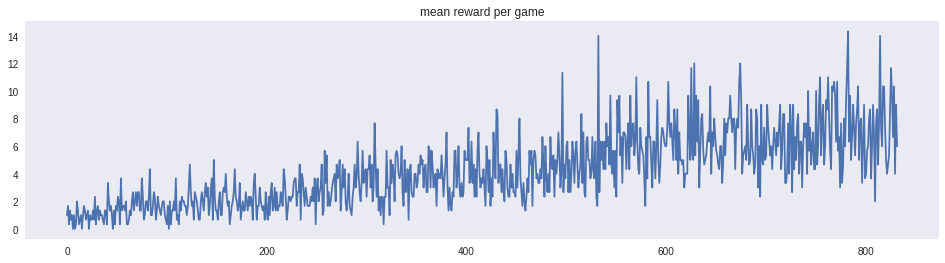

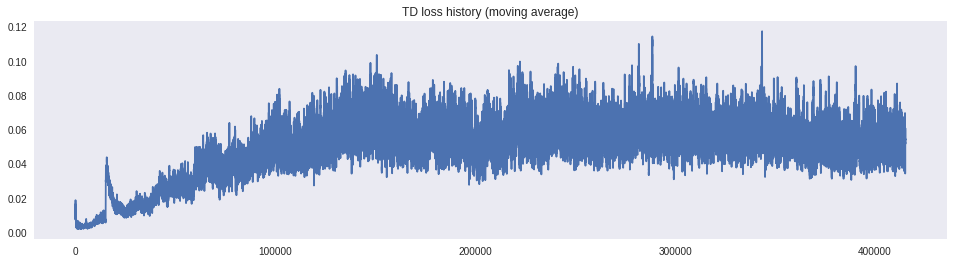




100%|█████████▉| 399903/400000 [7:19:09<00:15,  6.19it/s]


100%|█████████▉| 399905/400000 [7:19:09<00:12,  7.76it/s]


100%|█████████▉| 399907/400000 [7:19:09<00:09,  9.35it/s]


100%|█████████▉| 399910/400000 [7:19:09<00:08, 11.20it/s]


100%|█████████▉| 399913/400000 [7:19:10<00:06, 13.01it/s]


100%|█████████▉| 399915/400000 [7:19:10<00:05, 14.51it/s]


100%|█████████▉| 399918/400000 [7:19:10<00:05, 15.96it/s]


100%|█████████▉| 399920/400000 [7:19:10<00:04, 16.92it/s]


100%|█████████▉| 399922/400000 [7:19:10<00:04, 17.68it/s]


100%|█████████▉| 399924/400000 [7:19:10<00:04, 18.21it/s]


100%|█████████▉| 399926/400000 [7:19:10<00:04, 18.35it/s]


100%|█████████▉| 399928/400000 [7:19:10<00:03, 18.70it/s]


100%|█████████▉| 399931/400000 [7:19:10<00:03, 19.34it/s]


100%|█████████▉| 399933/400000 [7:19:11<00:03, 19.51it/s]


100%|█████████▉| 399935/400000 [7:19:11<00:03, 19.63it/s]


100%|█████████▉| 399938/400000 [7:19:11<00:03, 19.94it/s]


100%|█████████▉| 399941/400000 [7:19:

In [71]:
for i in trange(4 * (10 ** 5)):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.1)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
    
    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.figure(figsize=[36, 4])
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[36, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(pd.ewma(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

In [73]:
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(), directory="videos", force=True)
sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(100)]
env_monitor.close()

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [74]:
!ls ./videos

openaigym.episode_batch.1.227.stats.json
openaigym.manifest.1.227.manifest.json
openaigym.video.1.227.video000000.meta.json
openaigym.video.1.227.video000000.mp4
openaigym.video.1.227.video000001.meta.json
openaigym.video.1.227.video000001.mp4
openaigym.video.1.227.video000008.meta.json
openaigym.video.1.227.video000008.mp4
openaigym.video.1.227.video000027.meta.json
openaigym.video.1.227.video000027.mp4
openaigym.video.1.227.video000064.meta.json
openaigym.video.1.227.video000064.mp4


In [0]:
from google.colab import files

files.download('./videos/openaigym.video.1.227.video000064.mp4')